In [ ]:
import tensorflow as tf
import pandas as pd

In [ ]:
tfrecord_path = ["train_data.tfrecord", "val_data.tfrecord", "test_data.tfrecord"]

In [ ]:
csv_path="Dataset.csv"
PATH = "/content/drive/My Drive/"
file_path = "/content/drive/My Drive/Mcovers2.zip"
cover_path = "/content/Mcovers2/"

In [ ]:
val_ratio = 0.1
test_ratio = 0.2
BUFFER_SIZE = 1000
BATCH_SIZE = 32
steps_train = (50000*0.8) // BATCH_SIZE
steps_val = (50000*0.1) // BATCH_SIZE
steps_test = (50000*0.1) // BATCH_SIZE
IMG_DIM = (224, 224, 3)
outdim_size = 15
vocab_size = 15660
max_len = 100

def unzip_data(file_path):
  from zipfile import ZipFile
  with ZipFile(file_path, "r") as zip:
    zip.extractall()
    return "Data has been extracted"

unzip_data(file_path)

'Data has been extracted'

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# helper functions for writing tfrecord data
def load_csv():
    df = pd.read_csv(csv_path, header = 0, index_col = 0, encoding='latin1')

    # split the data into train, validation and test
    train_data, val_data = train_test_split(df, test_size=(test_ratio+val_ratio), random_state=21)
    val_data, test_data = train_test_split(val_data, test_size=test_ratio/(test_ratio+val_ratio), random_state=21)

    return train_data, val_data, test_data


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# functions for process texts
def get_token(texts, word_freq=10):
  words = texts.str.split(expand=True).stack().value_counts()
  words = pd.DataFrame(words, columns=["freq"])
  vocab_size = len(words[words.freq > word_freq])
  token = Tokenizer(num_words=vocab_size)
  token.fit_on_texts(texts)
  return token, vocab_size

def get_text_sequence(text, token, max_len=100):
  sequences = token.texts_to_sequences([text])
  return pad_sequences(sequences,maxlen=max_len).reshape(-1)

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def make_example(image_string, text_sequence, label, keras_hub=False):
    if keras_hub:
      text_seq = _bytes_feature(text_sequence.encode())
    else:
      text_seq = tf.train.Feature(int64_list=tf.train.Int64List(value=text_sequence))

    feature = {
        'image_string': _bytes_feature(image_string),
        'text_sequence': text_seq,
        'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecord(data, token, tfrecord_path, keras_hub=False):
    with tf.io.TFRecordWriter(tfrecord_path) as writer:
        for _,row in data.iterrows():
            img_file = cover_path+str(row["id"])+'.jpg'
            text_sequence = row["Descriptions"] if keras_hub else get_text_sequence(row["Descriptions"], token)
            label = row["cat_id"]
            image_string = open(img_file, 'rb').read()
            example = make_example(image_string, text_sequence, label, keras_hub)  
            writer.write(example.SerializeToString()) 

# healper functions for reading tfrecord data 
feature_description = {
    'image_string': tf.io.FixedLenFeature([], tf.string),
    'text_sequence': tf.io.FixedLenFeature([100], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
}

feature_description_hub = {
    'image_string': tf.io.FixedLenFeature([], tf.string),
    'text_sequence': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
}

def parse_image(image):
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [IMG_DIM[0], IMG_DIM[1]])
  return image


def parser(proto):
    parsed_features = tf.io.parse_single_example(proto, feature_description)
    image_string = parsed_features['image_string']
    image_string = parse_image(image_string)
    text_sequence = parsed_features['text_sequence']
    label = parsed_features['label']
    return (image_string, text_sequence), label

def parser_hub(proto):
    parsed_features = tf.io.parse_single_example(proto, feature_description_hub)
    image_string = parsed_features['image_string']
    image_string = parse_image(image_string)
    text_sequence = parsed_features['text_sequence']
    label = parsed_features['label']
    return (image_string, text_sequence), label

def get_dataset(tfrecord_path, keras_hub=False, batch_size=BATCH_SIZE):
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    if keras_hub:
        dataset = dataset.map(parser_hub, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    else:
        dataset = dataset.map(parser, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    #dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

    
def load_cat(newdata, tfrecord_path = "new.tfrecord", keras_hub=False):
    data = load_csv()
    token, _ = get_token(data[0].Descriptions)
    
    dataset = []
    for i in range(outdim_size):
        tfrecord_path = "test_cat"+str(i)+".tfrecord"
        write_tfrecord(newdata[i], token, tfrecord_path, keras_hub)
        dataset.append(get_dataset(tfrecord_path, keras_hub))

    return dataset

def load_data(first_time=True, keras_hub=False):
    if first_time:
        data = load_csv()
        token, _ = get_token(data[0].Descriptions)
        for i in range(3):
           write_tfrecord(data[i], token, tfrecord_path[i], keras_hub)

    # load the dataset    
    dataset = []   
    for i in range(3):
        data = get_dataset(tfrecord_path[i], keras_hub)
        dataset.append(data)
    return dataset

In [ ]:
train_data, val_data, test_data = load_data(True, True)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt


def train_model(model, epoch_num):
  
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2)
    checkpointer = ModelCheckpoint(filepath="temp_weights.h5", verbose=1, save_best_only=True, save_weights_only=True)
  
    history = model.fit(train_data.repeat(),
                        steps_per_epoch = steps_train,
                        epochs = epoch_num,
                        validation_data= val_data.repeat(),
                        validation_steps = steps_val,
                        use_multiprocessing=True,
                        callbacks=[checkpointer, earlystop])


    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    model.load_weights("temp_weights.h5")

    results = model.evaluate(test_data, use_multiprocessing=True, verbose=1)

    print('loss on test data: ', results)

    results = model.evaluate(val_data, use_multiprocessing=True, verbose=1)

    print('loss on validation data: ', results)
    return model

In [ ]:
# TRAIN MODEL
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt


# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


def train_model(model, epoch_num):
    temp_weight_path = "temp_weightsCONC.h5"
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=1)
    checkpointer = ModelCheckpoint(filepath=temp_weight_path, verbose=1, save_best_only=True, save_weights_only=True)
  
    history = model.fit(train_data.repeat(),
                        steps_per_epoch = steps_train,
                        epochs = epoch_num,
                        validation_data= val_data.repeat(),
                        validation_steps = steps_val,
                        use_multiprocessing=True,
                        callbacks=[checkpointer, earlystop])


    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    model.load_weights(temp_weight_path)

    results = model.evaluate(test_data, use_multiprocessing=True, verbose=1)

    print('loss on test data: ', results)

    results = model.evaluate(val_data, use_multiprocessing=True, verbose=1)

    print('loss on validation data: ', results)
    return model

In [ ]:
from tensorflow.keras import layers, models, optimizers, losses, regularizers, metrics, applications
import tensorflow_hub as hub

# constant for model compile
loss_fn = losses.sparse_categorical_crossentropy
optimizer_fn = optimizers.Adam()
metric_ls = ["accuracy", tf.keras.metrics.SparseTopKCategoricalAccuracy(3)]

def create_hubmodel_conc(img_base, text_base):
    """
    builds the whole model
    the structure of each sub-network is defined in build_mlp_net,
    and it can easily get substituted with a more efficient and powerful network like CNN
    """
    view1_model = build_hubnet_image(img_base)
    view2_model = build_hubnet_text(text_base)
    
    model_concat = layers.concatenate([view1_model.output, view2_model.output], axis=-1)
    out = layers.Dense(outdim_size, activation='softmax')(model_concat)
    model = models.Model(inputs=[view1_model.input, view2_model.input], outputs=out)
    
    model.compile(loss=loss_fn, optimizer=optimizer_fn, metrics=metric_ls)

    return model


def build_hubnet_image(img_base):
    model = models.Sequential()
    model.add(layers.Input(IMG_DIM))
    model.add(img_base)
    model.add(layers.Dense(outdim_size, activation="relu"))
    return model

def build_hubnet_text(text_base):
    model = models.Sequential()
    model.add(text_base)
    model.add(layers.Dense(outdim_size, activation="relu"))
    return model

In [ ]:
img_base = "https://tfhub.dev/tensorflow/resnet_50/feature_vector/1"
img_base = hub.KerasLayer(img_base, input_shape=[])
text_base = "https://tfhub.dev/google/universal-sentence-encoder/4"
text_base = hub.KerasLayer(text_base, input_shape=[], dtype=tf.string)

In [ ]:
model = create_hubmodel_conc(img_base, text_base)
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
keras_layer_5_input (InputLayer [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer_4 (KerasLayer)      (None, 2048)         23561152    input_3[0][0]                    
__________________________________________________________________________________________________
keras_layer_5 (KerasLayer)      (None, 512)          256797824   keras_layer_5_input[0][0]        
_______________________________________________________________________________________

Epoch 1/25
1250/1250 [==============================] - ETA: 0s - loss: 1.9961 - accuracy: 0.3566 - sparse_top_k_categorical_accuracy: 0.6369
Epoch 00001: val_loss improved from inf to 1.69912, saving model to temp_weights.h5
1250/1250 [==============================] - 164s 131ms/step - loss: 1.9961 - accuracy: 0.3566 - sparse_top_k_categorical_accuracy: 0.6369 - val_loss: 1.6991 - val_accuracy: 0.4555 - val_sparse_top_k_categorical_accuracy: 0.7518
Epoch 2/25
1250/1250 [==============================] - ETA: 0s - loss: 1.6193 - accuracy: 0.4757 - sparse_top_k_categorical_accuracy: 0.7650
Epoch 00002: val_loss improved from 1.69912 to 1.58136, saving model to temp_weights.h5
1250/1250 [==============================] - 164s 131ms/step - loss: 1.6193 - accuracy: 0.4757 - sparse_top_k_categorical_accuracy: 0.7650 - val_loss: 1.5814 - val_accuracy: 0.4946 - val_sparse_top_k_categorical_accuracy: 0.7815
Epoch 3/25
1250/1250 [==============================] - ETA: 0s - loss: 1.5316 - accur

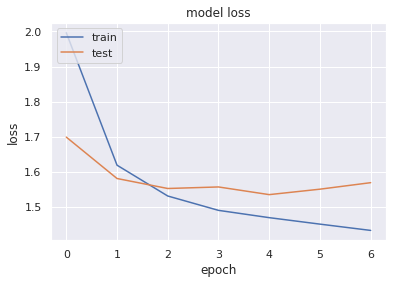

312/312 [==============================] - 34s 111ms/step - loss: 1.5374 - accuracy: 0.4991 - sparse_top_k_categorical_accuracy: 0.7911
loss on test data:  [1.5373598337173462, 0.4990985691547394, 0.7910656929016113]
156/156 [==============================] - 17s 110ms/step - loss: 1.5355 - accuracy: 0.4986 - sparse_top_k_categorical_accuracy: 0.7987
loss on validation data:  [1.535457968711853, 0.49859777092933655, 0.7986778616905212]


In [ ]:
model = train_model(model, 25)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [ ]:
tedf = pd.read_csv(csv_path, header = 0, index_col = 0, encoding='latin1')
cat_tup = tedf.groupby(["cat_id", "Genre"]).count().index.values
cat_dict=dict() 
for cat_id,cat in cat_tup: 
    cat_dict[cat_id] = cat
print(cat_dict)

{0: 'Adventure', 1: 'Arcade', 2: 'Fighting', 3: 'Indie', 4: 'Music', 5: 'Pinball', 6: 'Platform', 7: 'Puzzle', 8: 'Quiz/Trivia', 9: 'Racing', 10: 'Role-playing(RPG)', 11: 'Shooter', 12: 'Simulator', 13: 'Sport', 14: 'Strategy'}


In [ ]:
_,_,df = load_csv() # load train data 
#df = tedf
print("...df loaded")
BATCH_SIZE = 32
results = []
newdata = []

# seperate data based on category
for i in range(outdim_size):
  newdata.append(df[df.cat_id==i])

# write tfrecord file and load dataset outdim_siz number of dataset
dataset = load_cat(newdata, keras_hub=True)
print("...dataset loaded")

...df loaded
...dataset loaded


In [ ]:
cat_sample_size = df.groupby(["Genre", "cat_id"]).count().Descriptions

In [ ]:
cat_sample_size

Genre              cat_id
Adventure          0         1642
Arcade             1          380
Fighting           2          496
Indie              3         1087
Music              4          155
Pinball            5           86
Platform           6          605
Puzzle             7          739
Quiz/Trivia        8           94
Racing             9          398
Role-playing(RPG)  10         752
Shooter            11         859
Simulator          12         796
Sport              13         767
Strategy           14        1145
Name: Descriptions, dtype: int64

In [ ]:
cat_sample_size = df.groupby(["Genre", "cat_id"]).count().Descriptions

from collections import Counter

# each iteration the below code will count the predic and apend in the prediction list
pred_count = []
# list of dataframe that contains the prediction layer for each category
prob_df_list = []
for i in range(outdim_size):
  steps = cat_sample_size[i] // 32
  prob_y = model.predict(dataset[i].repeat(), steps=steps)
  pred_y = tf.argmax(prob_y, 1)
  pred_count.append(Counter(pred_y.numpy()))

  feat_cols = ['f'+str(k) for k in range(prob_y.shape[1])]
  prob_df = pd.DataFrame(prob_y,columns=feat_cols)
  prob_df["genre"] = [cat_dict[i] for k in range(prob_y.shape[0])]
  prob_df_list.append(prob_df)

# put all the predict into confusion matrix where row is truth value
conf_mat = pd.DataFrame(pred_count, columns=range(outdim_size))
conf_mat.fillna(0, inplace=True)

# prediction layer with true category
prob_df = pd.concat(prob_df_list, ignore_index=True, sort=False)

In [ ]:
df = prob_df.copy()

# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.18758719 0.14129733 0.10900455]


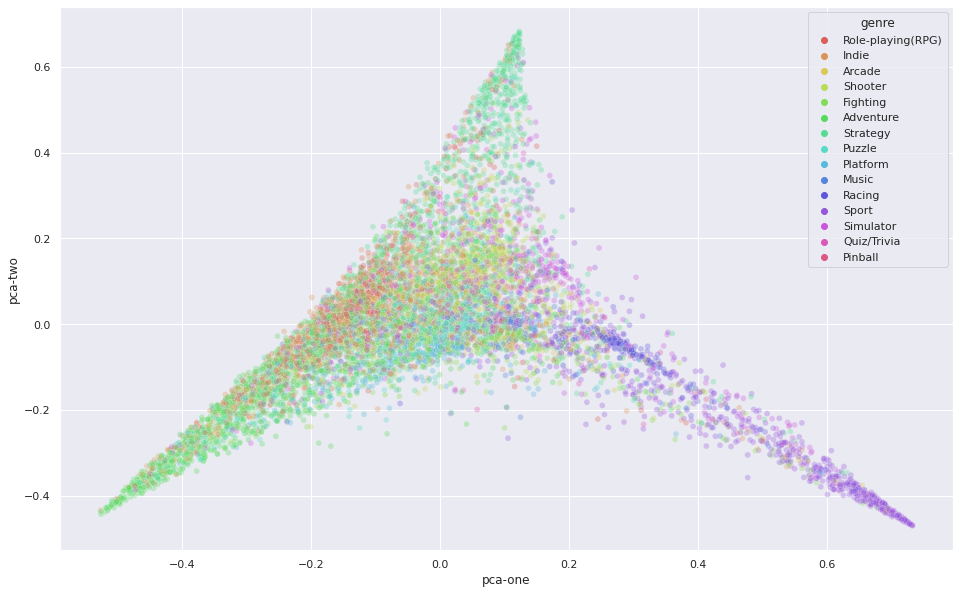

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="genre",
    palette=sns.color_palette("hls", outdim_size),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)

In [ ]:
N = 15000
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.18758723 0.14129728 0.10900459]


In [ ]:
import time
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9664 samples in 0.020s...
[t-SNE] Computed neighbors for 9664 samples in 2.196s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9664
[t-SNE] Computed conditional probabilities for sample 2000 / 9664
[t-SNE] Computed conditional probabilities for sample 3000 / 9664
[t-SNE] Computed conditional probabilities for sample 4000 / 9664
[t-SNE] Computed conditional probabilities for sample 5000 / 9664
[t-SNE] Computed conditional probabilities for sample 6000 / 9664
[t-SNE] Computed conditional probabilities for sample 7000 / 9664
[t-SNE] Computed conditional probabilities for sample 8000 / 9664
[t-SNE] Computed conditional probabilities for sample 9000 / 9664
[t-SNE] Computed conditional probabilities for sample 9664 / 9664
[t-SNE] Mean sigma: 0.050585
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.205627
[t-SNE] KL divergence after 300 iterations: 2.540541
t-SNE done! Time elapsed: 25.860132217

In [ ]:
import matplotlib.markers as markers
all_shapes=markers.MarkerStyle.markers.keys()
all_shapes
mark30 = list(all_shapes)[0:13]

In [ ]:
sns.set_style("dark")
sns.axes_style()

{'axes.axisbelow': True,
 'axes.edgecolor': 'white',
 'axes.facecolor': '#EAEAF2',
 'axes.grid': False,
 'axes.labelcolor': '.15',
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': True,
 'axes.spines.top': True,
 'figure.facecolor': 'white',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'grid.color': 'white',
 'grid.linestyle': '-',
 'image.cmap': 'rocket',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': '.15',
 'xtick.bottom': False,
 'xtick.color': '.15',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': '.15',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False}

<Figure size 2304x2304 with 0 Axes>

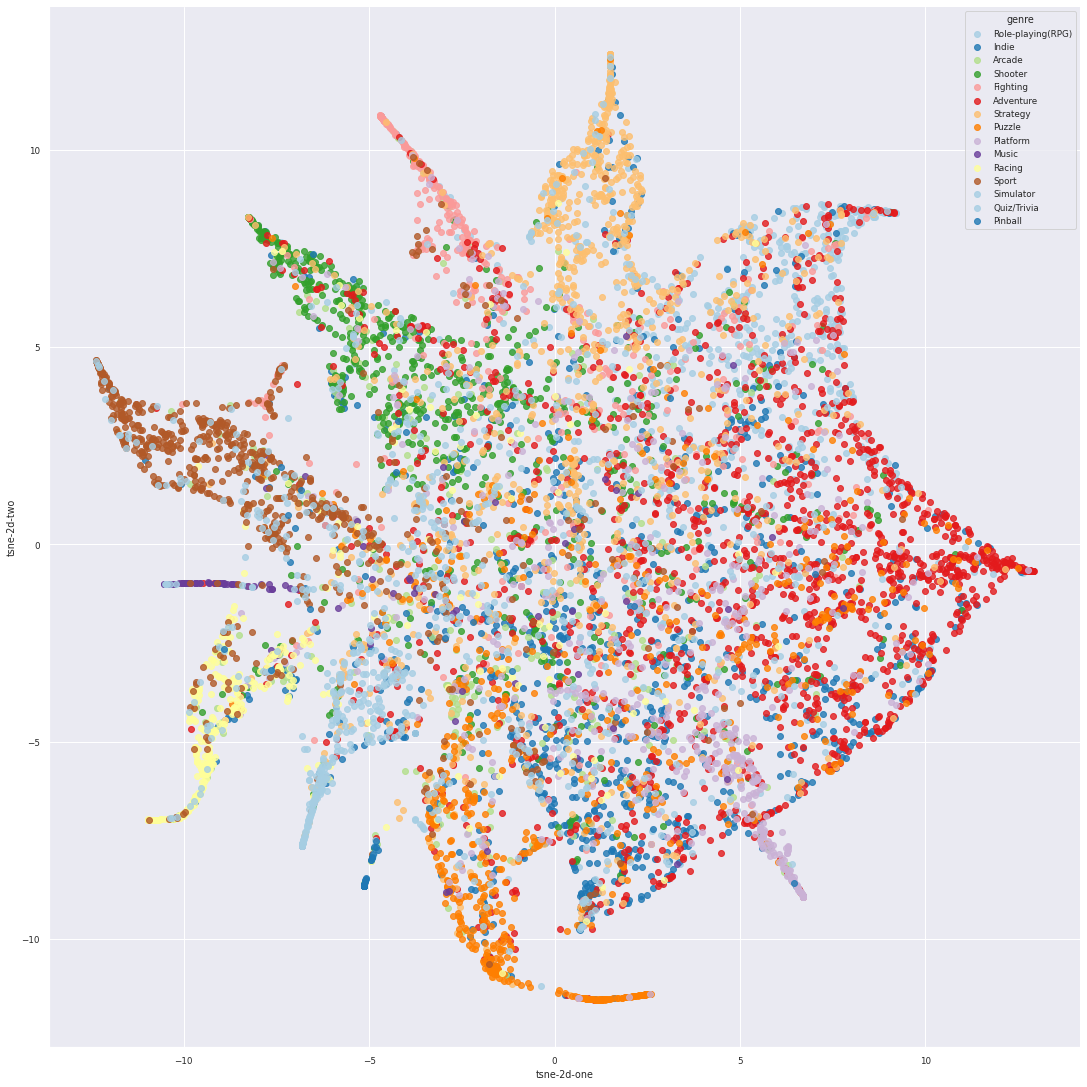

In [ ]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(32,32))
sns.set(font_scale=.8)
ax = sns.lmplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="genre",
    palette=sns.color_palette("Paired", 13),
    data=df_subset,
    legend="full",
    scatter=True, fit_reg=False, legend_out=False, height=15
)

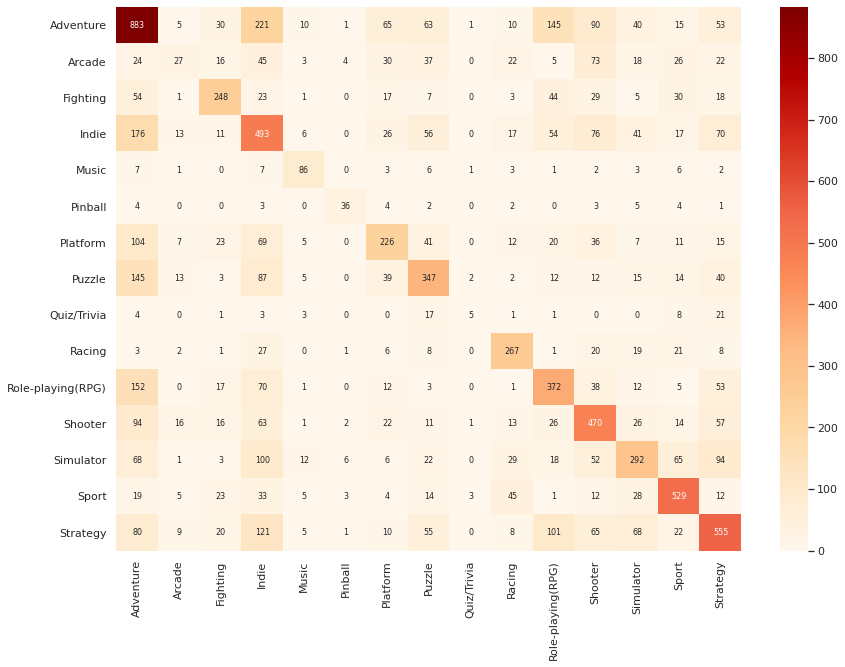

In [ ]:
df_cm = pd.DataFrame(conf_mat.values.astype(int), cat_dict.values(), cat_dict.values())
plt.figure(figsize=(14,10))
sns.set(font_scale=1) # for label size
sns.heatmap(df_cm, annot=True,fmt='d', annot_kws={"size": 8}, cmap="OrRd") # font size

plt.savefig("filename.png")
plt.show()

In [ ]:
for i in range(outdim_size):
  acc = conf_mat.values[i,i]/sum(conf_mat.loc[i,:])
  print(cat_dict[i]," (",str(i), "): ",  str(acc*100), " %")

Adventure  ( 0 ):  54.10539215686274  %
Arcade  ( 1 ):  7.670454545454546  %
Fighting  ( 2 ):  51.66666666666667  %
Indie  ( 3 ):  46.68560606060606  %
Music  ( 4 ):  67.1875  %
Pinball  ( 5 ):  56.25  %
Platform  ( 6 ):  39.23611111111111  %
Puzzle  ( 7 ):  47.14673913043478  %
Quiz/Trivia  ( 8 ):  7.8125  %
Racing  ( 9 ):  69.53125  %
Role-playing(RPG)  ( 10 ):  50.54347826086957  %
Shooter  ( 11 ):  56.49038461538461  %
Simulator  ( 12 ):  38.02083333333333  %
Sport  ( 13 ):  71.875  %
Strategy  ( 14 ):  49.55357142857143  %


In [ ]:
sum(conf_mat[0])

174.0

In [ ]:
s=0
for i in range(0,21):
  s=s+sum(conf_mat[i])

In [ ]:
s

49632.0